### Previsão de Faturamento para Serviços de Coleta de Resíduos
#### Banco de dados geral (todos os serviços)
Modelo utilizando SARIMAX e Modelos de Machine Learning
Dados das médias semanais de faturamento

#### IMPORTANDO BIBLIOTECAS

In [100]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

import math
from math import sqrt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [101]:
def mostra_resultados():
    mean_error = []

    print("1. Valores Previstos Por Algoritmo de Predição:\n")
    print(df_preds.tail(len(dados_real)).round(2))
    print('\n')
    print("2. Gráfico de Métricas Por Algoritmo de Predição:\n")
    plt.figure(figsize=(15,8))
    plt.plot(range(len(df_preds['ARIMA'])),df_preds['ARIMA'], 'g--', label='ARIMA')
    plt.plot(range(len(df_preds['LR'])),df_preds['LR'], ':', label='LR')
#     plt.plot(range(len(df_preds['DT'])),df_preds['DT'], ':', label='DT')
    plt.plot(range(len(df_preds['RF'])),df_preds['RF'], ':', label='RF')
    plt.plot(range(len(df_preds['GB'])),df_preds['GB'], ':', label='GB')
    plt.plot(range(len(df_preds['LGBM'])),df_preds['LGBM'], ':', label='LGBM')
    plt.plot(range(len(df_preds['MLP'])),df_preds['MLP'], ':', label='MLP')
    plt.plot(range(len(df_preds['Real'])),df_preds['Real'], 'b-', label='Real')
    plt.legend()
    plt.title('Gráfico Real x Previsto')
    plt.show()
    
    print("\n3. Valores Das Métricas de Cada Algoritmo de Predição:\n")
    print(df_metricas)

    print('\n')
    
    # Gráfico para Análise da Predição (grid)
    print("4. Gráfico de Dispersão Para Análise das Predições:\n")
    fig, ax = plt.subplots(2, 3, figsize=(16,6))

    for i,col in enumerate(df_preds.columns[1:]):
         #random_df.plot(kind='scatter', x=col, y='MEDV', ax=ax[i])
         if i <= 2:
            sns.regplot(x=df_preds[col], y=df_preds["Real"], ax=ax[0,i])
         else:
            sns.regplot(x=df_preds[col], y=df_preds["Real"], ax=ax[1,i-3])     

    # ax[1,2].axis('off')                  # HIDES AXES ON LAST ROW AND COL

    fig.suptitle('Análise da Predição')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()
    plt.clf()
    plt.close()

   
    # Gráfico do Erro (RMSE) passo a passo para o melhor modelo (r2)
    
    # Identifica o melhor modelo
    melhor_modelo = df_metricas['R2'].max()
    indice = np.where(df_metricas['R2'] == melhor_modelo)[0] # indice da linha do modelo
    modelo = df_metricas['Modelo'].loc[indice[0]] # nome do melhor modelo
    
    print('\n')
    print(f'5. Gráfico Do Erro Em Cada Passo Para o Melhor Modelo ({modelo}):\n')
    
    erro = ((np.array(df_preds['Real']) - np.array(df_preds[modelo]))**2)**(1/2)

    passos = df_preds.shape[0]
    
    # Plotando o gráfico de erro
    indice = np.arange(0,passos)
    plt.figure(figsize=(15,5))
    plt.plot(erro.round(2), '.--', color='g', markersize=6)
    plt.title('RMSE Para Cada Passo')
    plt.xlabel('Passos')
    plt.ylabel('Erro')
    for x,y in zip(indice, erro):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x, y), xytext=(x-0.1, y+.075))
    plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
    plt.yticks([x for x in np.linspace(min(erro)-0.2, max(erro)+0.2, 10)])
    plt.grid(axis='y')
    plt.show()

#### CARREGANDO DADOS E CRIANDO FEATURES TEMPORAIS

In [102]:
df=pd.read_csv('residuos.csv')
df['Data'] = pd.to_datetime(df['Data'], format='%Y%m%d')
# Totaliza os valores por dia
df = df.groupby('Data')['Valor'].sum().reset_index()
df.sort_values('Data')

df.head()

,Data,Valor
0,2017-01-02,45671.11
1,2017-01-03,707912.02
2,2017-01-04,403451.35
3,2017-01-05,1198760.64
4,2017-01-06,192867.29


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    1111 non-null   datetime64[ns]
 1   Valor   1111 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.5 KB


In [104]:
# Calcula a média diária e totaliza por semana
# y = df['Valor'].resample('MS').mean() #calcula a média por mês
# y = df['Valor'].resample('W-MON').sum()#calcula a média por semana
y = df.resample('W', on='Data')['Valor'].mean()#calcula a média por semana*
df = y.to_frame().reset_index()

In [105]:
# Cria campos para dia da semana, mês e ano
df['d_semana'] = df['Data'].dt.strftime("%u")
df['d_mes'] = df['Data'].dt.strftime("%d")
df['d_ano'] = df['Data'].dt.strftime("%j")

df['d_semana'] = df['d_semana'].astype(float)
df['d_mes'] = df['d_mes'].astype(float)
df['d_ano'] = df['d_ano'].astype(float)

df.head(7)

,Data,Valor,d_semana,d_mes,d_ano
0,2017-01-08,509732.4820,7.0,8.0,8.0
1,2017-01-15,665328.4525,7.0,15.0,15.0
2,2017-01-22,596358.8780,7.0,22.0,22.0
3,2017-01-29,260083.9380,7.0,29.0,29.0
4,2017-02-05,371491.9825,7.0,5.0,36.0
5,2017-02-12,565506.2320,7.0,12.0,43.0
6,2017-02-19,773669.3720,7.0,19.0,50.0


### VISUALIZANDO DADOS

##### Faturamento Semanal

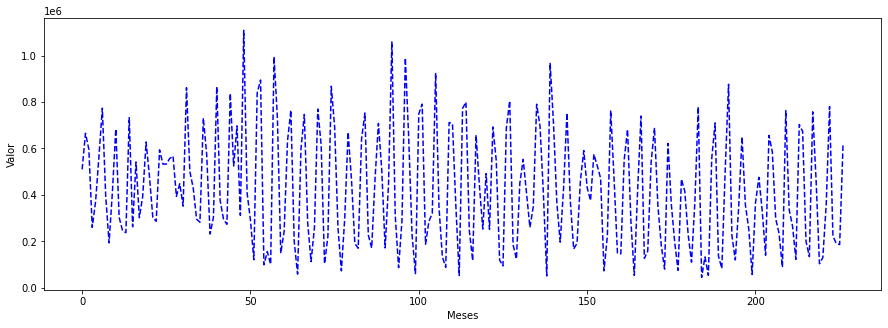

In [106]:
plt.figure(figsize=(15,5))
plt.plot(range(len(df)),df['Valor'], 'b--')
plt.xlabel('Meses')
plt.ylabel('Valor')
plt.show()

#### Série Estacionária (Média Constante)?

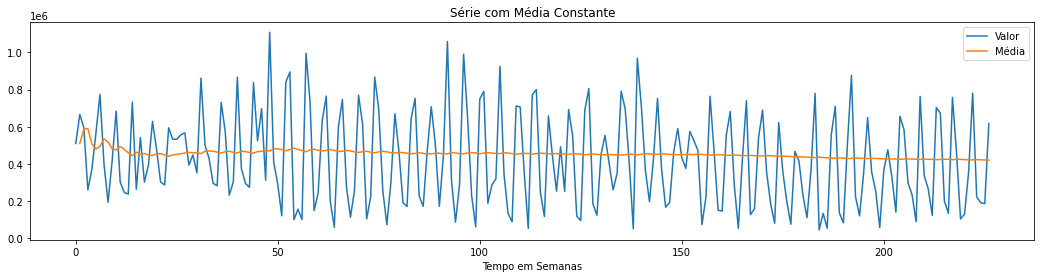

In [107]:
valor = df['Valor'].to_numpy()

#Criando uma média que se expande da primeira quantidade e acumulado até cada dia anterior
mean = [np.mean(valor[:x]) for x in range(len(valor))]
plt.figure(figsize=(18,4))
plt.plot(valor, label='Valor')
plt.plot(mean, label='Média')
plt.title('Série com Média Constante')
plt.xlabel('Tempo em Semanas')
# plt.xlim(1000,1400)
plt.legend()
plt.show()

#### Teste de Dickey Fuller
Testes estatísticos para confirmar se a séries é estacionária. Vamos usar dois testes: o teste de [Dickey Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) e o teste [KPSS](https://en.wikipedia.org/wiki/KPSS_test).

Primeiramente vamos usar o teste de Dickey Fuller, usarei o [valor P](https://pt.wikipedia.org/wiki/Valor-p) base de 5%, ou seja, caso o valor P esteja abaixo desses 5% significa que a série é estatisticamente estacionária. 

Além disso, existe o **Teste estatístico** do modelo, onde estes valores podem ser comparados com os **valores críticos** de 1%, 5% e 10%, caso o teste estatístico esteja abaixo de algum valor critico escolhido a série será estacionária:

In [108]:
#Teste de Dickey Fuller
adfinput = adfuller(df['Valor']) # limita o teste da série em 365 exemplos
adftest = pd.Series(adfinput[0:4], index=['Teste Estatistico Dickey Fuller','Valor-P',
                                          'Lags Usados','Número de observações usadas'])
adftest = round(adftest,4)
    
for key, value in adfinput[4].items():
    adftest["Valores Críticos (%s)"%key] = value.round(4) 
adftest

Teste Estatistico Dickey Fuller     -1.9971
Valor-P                              0.2878
Lags Usados                         12.0000
Número de observações usadas       214.0000
Valores Críticos (1%)               -3.4613
Valores Críticos (5%)               -2.8751
Valores Críticos (10%)              -2.5740
dtype: float64

Neste caso o teste de Dickey Fuller indicou que a série não é estacionária (Valor P de 28,78% é maior que o valor crítico de 5%.

#### Teste KPSS
O teste KPSS, ao contrário do teste de Dickey Fuller, já pressupõe que a série é estacionária e só não será se o valor P for inferior a 5% ou o teste estatístico for menor que algum valor crítico escolhido:

In [17]:
kpss_input = kpss(df['Valor']) # limita o teste da série em 365 exemplos
kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Valores Críticos (%s)"%key] = value 
kpss_test

Teste Statistico KPSS       0.8937
Valor-P                     0.0100
Lags Usados                15.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64

Neste caso o teste de KPSS indicou que a série é NÃO é estacionária (Valor P de 1% é menor que o valor crítico de 5%.

#### Histograma do Faturamento Diário

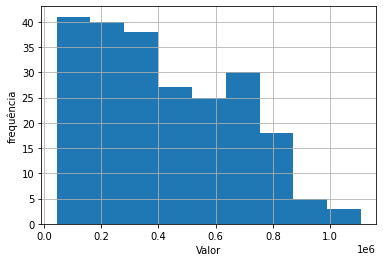

In [109]:
df['Valor'].hist(bins='auto')
plt.xlabel('Valor')
plt.ylabel('frequência')
plt.show()

#### Análise de Autocorrelação

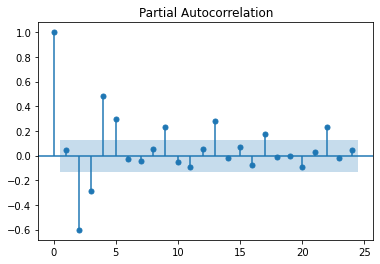

In [110]:
plot_pacf(df['Valor'])
plt.show()

#### Dataset para o Modelo

In [119]:
# Seleciona colunas para permanecer no dataset do modelo
df_model = df.filter(['Valor','d_semana','d_mes','d_ano', 'Feriado'])

#### MODELANDO COMO UM PROBLEMA DE SÉRIE TEMPORAL

In [112]:
time_steps = 52 # 52 semanas no ano
test_size = 4

train_size = int(len(df_model)-(test_size))
train, test = df_model.iloc[0:train_size], df_model.iloc[(train_size-time_steps):len(df_model)]
print(len(train), len(test))

223 56


In [113]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps),0].to_numpy()
        v = np.append(v,X.iloc[i + time_steps,1])#d_semana
        v = np.append(v,X.iloc[i + time_steps,2])#d_mes
        v = np.append(v,X.iloc[i + time_steps,3])#d_ano
#         v = np.append(v,X.iloc[i + time_steps,4])#feriados
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train['Valor'], time_steps)
X_test, y_test = create_dataset(test, test['Valor'], time_steps)

print("Treino:", len(X_train), "Teste:", len(X_test))

# X_train[0]

Treino: 171 Teste: 4


#### VALIDANDO O MODELO

In [120]:
# Função para validar o modelo SARIMAX
def validacao_arima(model):
    dt_ini = df['Data'].iloc[-test_size]
    pred = model.get_prediction(start=pd.to_datetime(dt_ini), dynamic=False)
    return pred.predicted_mean.values

In [121]:
# Função para validar os modelos de Machine Learning
def validacao(model):
    preds = []

    base_teste = np.copy(X_test)

    for i in range(len(base_teste)):
        y_pred = model.predict(np.array([base_teste[i]]))[0]
        preds.append(y_pred)

        for k in range(len(preds)):

            if i<len(base_teste):
                if k < time_steps:
                    if(i<len(base_teste)-1):
                        base_teste[i+1][(time_steps-1)-k] = preds[(len(preds)-1)-k]
                
       
    return preds

#### Gera as métricas das predições

In [116]:
# Gera as métricas das predições
def metricas(real, predito):
    rmse = round(sqrt(mean_squared_error(real,predito)),2)
    mae  = round(mean_absolute_error(real,predito),2)
    mape = round(100*mean_absolute_percentage_error(real,predito),2)
    r2   = round(r2_score(real,predito),4)
    return rmse, mae, mape, r2

#### CRIANDO E TREINANDO UM MODELO

In [117]:
# Prepare models
models = []
models.append(('ARIMA', sm.tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1,1,0,52),
                                                        enforce_invertibility=False)))
models.append(('LR', LinearRegression()))
# models.append(('DT', DecisionTreeRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('LGBM', LGBMRegressor()))
models.append(('MLP', MLPRegressor()))
# Evaluate each model in turn
names = []
preds = {}
df_preds    = pd.DataFrame()
df_metricas = pd.DataFrame()
dados_real  = df_model.iloc[(train_size):len(df_model),0].to_numpy()
df_preds['Real'] = dados_real
idx = 0
for name, mod in models:
    names.append(name)
    if name == 'ARIMA':
        model = mod.fit()
        predito = validacao_arima(model)
    else:
        model = mod.fit(X_train, y_train)
        predito = validacao(model)
    preds[name] = predito
    # Cria colunas no dataset para as predições de cada modelo
    df_preds[name] = preds[name]
    rmse, mae, mape, r2 = metricas(dados_real, predito)
    
    df_metricas.loc[idx,'Modelo'] = name
    df_metricas.loc[idx,'MAE']  = mae
    df_metricas.loc[idx,'RMSE'] = rmse
    df_metricas.loc[idx,'MAPE(%)'] = mape
    df_metricas.loc[idx,'R2']   = r2
    idx += 1

1. Valores Previstos Por Algoritmo de Predição:

        Real      ARIMA         LR         RF         GB       LGBM        MLP
0  222107.59  310772.14  262012.47  330232.59  241848.49  229163.62  234310.35
1  190551.25  243486.55   92610.40  218286.07  193541.04  232510.95  188976.46
2  186117.31   88969.44  112741.67  216337.66  150975.66  174077.72  121096.39
3  616894.22  619119.95  757857.13  608866.76  699429.47  646597.02  687471.50


2. Gráfico de Métricas Por Algoritmo de Predição:



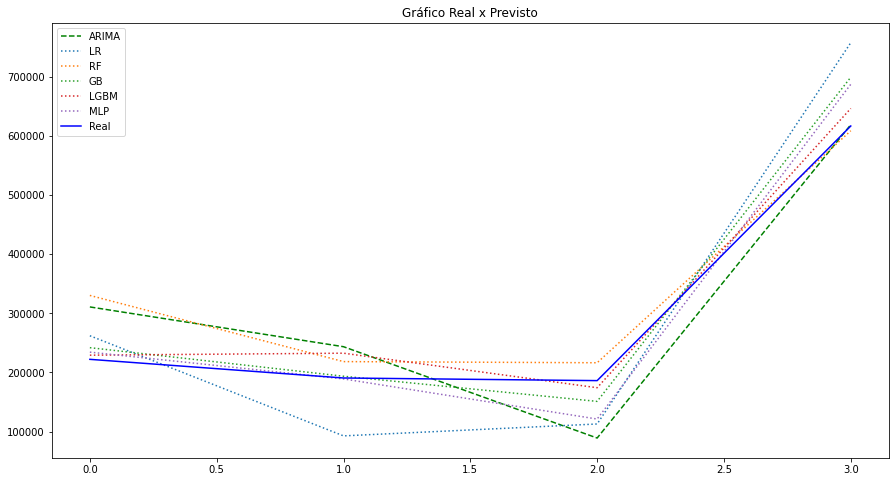


3. Valores Das Métricas de Cada Algoritmo de Predição:

  Modelo       MAE      RMSE  MAPE(%)      R2
0  ARIMA  60243.36  70898.18    30.06  0.8470
1     LR  88046.07  95445.45    32.91  0.7226
2     RF  43526.91  57961.07    20.19  0.8977
3     GB  35101.89  45950.09    10.68  0.9357
4   LGBM  22689.53  26634.62     9.12  0.9784
5    MLP  37343.93  48374.21    13.17  0.9288


4. Gráfico de Dispersão Para Análise das Predições:



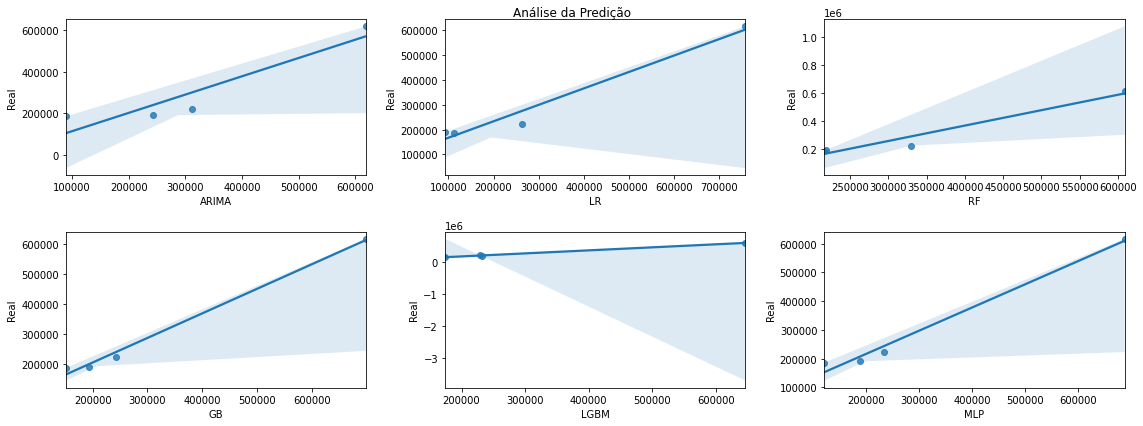



5. Gráfico Do Erro Em Cada Passo Para o Melhor Modelo (LGBM):



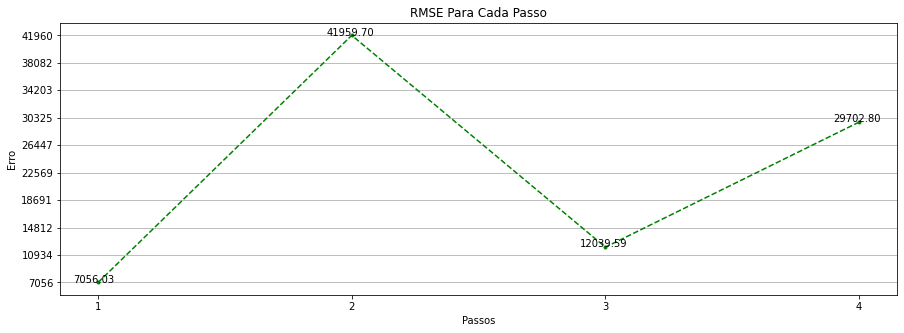

In [118]:
mostra_resultados()